# Análisis de datos en twitter 


### Día Internacional de la Eliminación de la Violencia contra la Mujer (25 de noviembre)


In [1]:
#Librerías
import sqlite3
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import datetime
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 3.	Implementación

## 3.1.	Extracción de los datos desde Twitter

Para la extracción de los datos desde Twitter se utiliza un script en Python almacenado en el archivo data_25N_academic.py en el cual, mediante Streaming desde domingo 21 al domingo 27 de noviembre, se obtuvo la siguiente información: id, username, text, created_at, lang, referenced_tweets.id, referenced_tweets.type

Posteriormente se vio la necesidad de obtener la informacion de la descripcion y localizacion del usuario lo cual se obtuvo mediante Paginator en el archivo nuevo_search.py


#### Carga de tweets desde la base de datos

In [2]:
# Carga base de datos con tweets en un dataframe
con = sqlite3.connect("./database/tweets_25N_completo.db")
df = pd.read_sql_query("SELECT * FROM tweets", con)
con.close()

In [3]:
#Tamaño de los datos
df.shape

(307396, 9)

## 3.2.	Transformación de datos

In [4]:
#Estructura del DataFrame
df.head()

,id_tweet,username,tweet_text,tweet_created_at,tweet_lang,id_rt_tweet,type_rt,description,location
0,1594506213009629187,RostroColectivo,💜Nos sobran razones para volver a las calles e...,2022-11-21 01:41:20+00:00,es,N/A,N/A,"Plataforma de articulación, encuentro y planea...",None
1,1594507056245096448,drjasf1,"RT @lagunes28: El arte callejero feminista, de...",2022-11-21 01:44:41+00:00,es,1594399504606040064,retweeted,,"Distrito Capital, Venezuela"
2,1594507073584234496,Allyta13,RT @sybelmartinez: Mañana en @humanizandonos8 ...,2022-11-21 01:44:45+00:00,es,1594504792465981440,retweeted,Ally,None
3,1594507130748522496,esloque68112740,RT @Salome181: Un llamado a todos los colectiv...,2022-11-21 01:44:59+00:00,es,1594493877276270593,retweeted,,None
4,1594507202823348229,mariapprada,RT @UJIuniversitat: V Ciclo Internacional de C...,2022-11-21 01:45:16+00:00,es,1594375598188761092,retweeted,Bibliotecaria. Docente. Lectora.,None


In [5]:
#Tipos de datos
df.dtypes

id_tweet             int64
username            object
tweet_text          object
tweet_created_at    object
tweet_lang          object
id_rt_tweet         object
type_rt             object
description         object
location            object
dtype: object

In [6]:
#Tamaño de los datos
df.shape

(307396, 9)

### 3.2.1.	Transformación de tipos de datos

In [7]:
#Transformar campo de fecha
df['tweet_created_at'] = pd.to_datetime(df['tweet_created_at'],format='%Y-%m-%d %H:%M:%S')

In [8]:
#Transformar ID rt_tweet
df['id_rt_tweet'] = df['id_rt_tweet'].replace('N/A', 0).astype('int64')

In [9]:
#Tipos de datos
df.dtypes

id_tweet                     int64
username                    object
tweet_text                  object
tweet_created_at    datetime64[ns]
tweet_lang                  object
id_rt_tweet                  int64
type_rt                     object
description                 object
location                    object
dtype: object

### 3.2.1.	Creación de nuevas columnas

In [10]:
#Creacion de campo date
df['tweet_date']=df['tweet_created_at'].dt.date

In [11]:
#Creacion de campo target_username

#Busqueda por id_tweet
df_merged = pd.merge(df, 
                     df.iloc[:,0:2], 
                     left_on ='id_rt_tweet', 
                     right_on ='id_tweet', 
                     how ='left',
                    suffixes=('', '_y'))
df_tweets = df_merged.drop(['id_tweet_y'], axis=1)
df_tweets.rename(columns = {'username_y': 'target_username'}, inplace = True)

In [12]:
#Extraer usuario destino del tweet
regex_rt=r'(^RT @[a-zA-Z0-9_]*)'
df_tweets["rt"] = df_tweets["tweet_text"].str.extract(regex_rt)   
df_tweets['rt'] = df_tweets['rt'].str.replace(r'RT @', '')
df_tweets['target_username'] = df_tweets['target_username'].fillna(df_tweets['rt'])
df_tweets = df_tweets.drop(['rt'], axis=1)


In [13]:
#Tipos de datos
df_tweets.dtypes

id_tweet                     int64
username                    object
tweet_text                  object
tweet_created_at    datetime64[ns]
tweet_lang                  object
id_rt_tweet                  int64
type_rt                     object
description                 object
location                    object
tweet_date                  object
target_username             object
dtype: object

In [14]:
#Estructura del DataFrame
df_tweets.head()

,id_tweet,username,tweet_text,tweet_created_at,tweet_lang,id_rt_tweet,type_rt,description,location,tweet_date,target_username
0,1594506213009629187,RostroColectivo,💜Nos sobran razones para volver a las calles e...,2022-11-21 01:41:20,es,0,N/A,"Plataforma de articulación, encuentro y planea...",None,2022-11-21,NaN
1,1594507056245096448,drjasf1,"RT @lagunes28: El arte callejero feminista, de...",2022-11-21 01:44:41,es,1594399504606040064,retweeted,,"Distrito Capital, Venezuela",2022-11-21,lagunes28
2,1594507073584234496,Allyta13,RT @sybelmartinez: Mañana en @humanizandonos8 ...,2022-11-21 01:44:45,es,1594504792465981440,retweeted,Ally,None,2022-11-21,sybelmartinez
3,1594507130748522496,esloque68112740,RT @Salome181: Un llamado a todos los colectiv...,2022-11-21 01:44:59,es,1594493877276270593,retweeted,,None,2022-11-21,Salome181
4,1594507202823348229,mariapprada,RT @UJIuniversitat: V Ciclo Internacional de C...,2022-11-21 01:45:16,es,1594375598188761092,retweeted,Bibliotecaria. Docente. Lectora.,None,2022-11-21,UJIuniversitat


### 3.2.3.	Filtros

In [15]:
#Tweets por idioma
df_tweets.groupby(['tweet_lang']).count()

,id_tweet,username,tweet_text,tweet_created_at,id_rt_tweet,type_rt,description,location,tweet_date,target_username
tweet_lang,,,,,,,,,,
art,4,4,4,4,4,4,2,0,4,4
ca,192,192,192,192,192,192,110,81,192,150
de,147,147,147,147,147,147,9,4,147,99
en,174,174,174,174,174,174,51,39,174,126
es,303030,303030,303030,303030,303030,303030,250642,150428,303030,256686
eu,12,12,12,12,12,12,7,7,12,6
fr,21,21,21,21,21,21,9,4,21,15
ht,1,1,1,1,1,1,1,0,1,0
in,8,8,8,8,8,8,4,1,8,5


In [16]:
#Filtro de idioma
df_tweets = df_tweets.loc[df_tweets['tweet_lang'] == "es"]

In [17]:
#Tweets por fecha
df_tweets.groupby(['tweet_date']).count()

,id_tweet,username,tweet_text,tweet_created_at,tweet_lang,id_rt_tweet,type_rt,description,location,target_username
tweet_date,,,,,,,,,,
2022-11-21,6177,6177,6177,6177,6177,6177,6177,5873,3437,4896
2022-11-22,9260,9260,9260,9260,9260,9260,9260,8457,5192,7568
2022-11-23,12773,12773,12773,12773,12773,12773,12773,11607,7137,10501
2022-11-24,24259,24259,24259,24259,24259,24259,24259,20192,12891,17808
2022-11-25,164205,164205,164205,164205,164205,164205,164205,138755,86115,136229
2022-11-26,66719,66719,66719,66719,66719,66719,66719,51370,27607,62253
2022-11-27,12992,12992,12992,12992,12992,12992,12992,10680,5784,11810
2022-11-28,6645,6645,6645,6645,6645,6645,6645,3708,2265,5621


In [18]:
#Filtro de fecha
df_tweets = df_tweets.loc[df_tweets['tweet_date'] != datetime.date(2022,11,28)]

In [19]:
#Tamaño de los datos
df_tweets.shape

(296385, 11)

In [20]:
#Generacion de hashtags
regex_hashtag = r'(#[A-Za-z_ÑñÁáÉéÍíÓóÚú0-9_]*)'
aux = df_tweets["tweet_text"].str.extractall(regex_hashtag)     
df2 = df_tweets.join(aux[0].unstack()).fillna('')
df2.fillna(' ', inplace=True)
df3 = df2.iloc[:,11:-1]
df4 = df3.values.tolist()
flat_list = [item for sublist in df4 for item in sublist]
df_hashtags = pd.DataFrame(flat_list)
df_hashtags.replace('', np.nan, inplace=True)
df_hashtags= df_hashtags.dropna().reset_index(drop=True)
df_hashtags.columns = ['hashtags']
df_hashtags.loc[:,'hashtags'] = df_hashtags.loc[:,'hashtags'].str.lower()


### 3.2.3. Generación de información adicional

In [21]:
#Hashtags
df_hashtags.head()

,hashtags
0,#25n
1,#oaxaca
2,#felizdomingo
3,#25n
4,#25nov


In [22]:
# Transformar texto
def transform_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'@\w+',' ', sentence) #usernames
    sentence = re.sub(r"#\w+",' ', sentence) #Hashtags
    sentence = re.sub(r'\bhttps?://[^\s]*',' ', sentence) #links
    sentence = re.sub(r'\d+',' ', sentence) #numeros
    sentence = re.sub(r'&', ' ', sentence) # Specific for &
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    sentence = re.sub(r'\b\w{1}\b', ' ', sentence) #One word
    sentence = ' '.join(sentence.split())
    return sentence

def tokenize(sentence):
    list_of_words = sentence.split(" ")
    stop_words = set(stopwords.words('spanish'))
    filtered_words = []
    for word in list_of_words: 
        if word not in stop_words: 
            filtered_words.append(word) 

    return filtered_words



In [23]:

def clean_text(df,column):
    
    lists_of_text = []

    for text in df[column]:
        sentence = str(text)

     
        sentence = transform_text(sentence)
        
        list_of_words = tokenize(sentence) # Tokenization
    
        
       
        lists_of_text.append(' '.join(list_of_words))

    return lists_of_text


In [24]:
# Limpieza de textos
df_tweets['clean_text'] = clean_text(df_tweets,'tweet_text')


df_tweets.head()

,id_tweet,username,tweet_text,tweet_created_at,tweet_lang,id_rt_tweet,type_rt,description,location,tweet_date,target_username,clean_text
0,1594506213009629187,RostroColectivo,💜Nos sobran razones para volver a las calles e...,2022-11-21 01:41:20,es,0,N/A,"Plataforma de articulación, encuentro y planea...",None,2022-11-21,NaN,sobran razones volver calles cifras queremos c...
1,1594507056245096448,drjasf1,"RT @lagunes28: El arte callejero feminista, de...",2022-11-21 01:44:41,es,1594399504606040064,retweeted,,"Distrito Capital, Venezuela",2022-11-21,lagunes28,rt arte callejero feminista recuerda defensoras
2,1594507073584234496,Allyta13,RT @sybelmartinez: Mañana en @humanizandonos8 ...,2022-11-21 01:44:45,es,1594504792465981440,retweeted,Ally,None,2022-11-21,sybelmartinez,rt mañana conversaremos valientes mujeres cuya...
3,1594507130748522496,esloque68112740,RT @Salome181: Un llamado a todos los colectiv...,2022-11-21 01:44:59,es,1594493877276270593,retweeted,,None,2022-11-21,Salome181,rt llamado colectivos colectivas sociales unir...
4,1594507202823348229,mariapprada,RT @UJIuniversitat: V Ciclo Internacional de C...,2022-11-21 01:45:16,es,1594375598188761092,retweeted,Bibliotecaria. Docente. Lectora.,None,2022-11-21,UJIuniversitat,rt ciclo internacional conferencias feminismes...


In [25]:
#Creacion de tabla con información unica del usuario
df_usuarios_aux = df_tweets.iloc[:,[1,7,8]]

In [26]:
df_usuarios = df_usuarios_aux.drop_duplicates(subset='username', keep="first")

In [27]:
# Cantidad de usuarios únicos
df_usuarios.shape

(148433, 3)

In [28]:
df_usuarios['clean_descripcion'] = clean_text(df_usuarios,'description')

C:\Users\aemartinez\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 3.2 Análisis de datos

### 3.3.1.	Tipos de tweets

In [29]:
# Distribución de tweets por tipo
df_groups = df_tweets.groupby(['type_rt'])['id_tweet'].count().reset_index().sort_values(by='id_tweet',ascending=False)

In [30]:
df_groups = pd.DataFrame(df_groups)

[(0.0, 260000.0)]

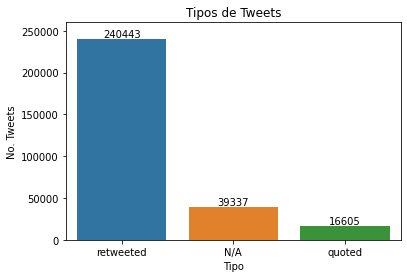

In [31]:
# Gráfico de tweets tipo
ax = sns.barplot(x='type_rt', y='id_tweet', data=df_groups)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Tipo', ylabel='No. Tweets',title="Tipos de Tweets")
ax.set(ylim=(0, 260000))

### 3.3.2.	Hashtags más frecuentes

In [32]:
# Hashtags más usados
aux2 = df_hashtags.hashtags.value_counts()
h_groups = pd.DataFrame(aux2).reset_index().head(10)

[(0.0, 150000.0)]

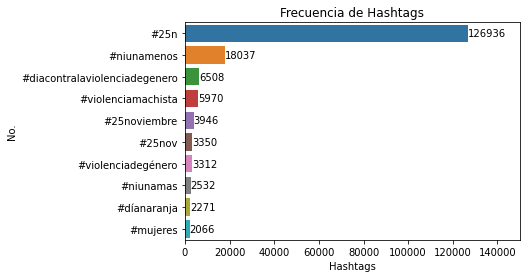

In [33]:
# Hashtags más usados
ax = sns.barplot(x='hashtags', y='index', data=h_groups)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Hashtags', ylabel='No.', title="Frecuencia de Hashtags")
ax.set(xlim=(0, 150000))


### 3.3.3.	Tweets por día

In [34]:
# Distribución de tweets por fecha
df_fecha = df_tweets.groupby(['tweet_date'])['id_tweet'].count().reset_index()

[Text(0.5, 0, 'Tipo'),
 Text(0, 0.5, 'No. Tweets'),
 Text(0.5, 1.0, 'Tipos de Tweets')]

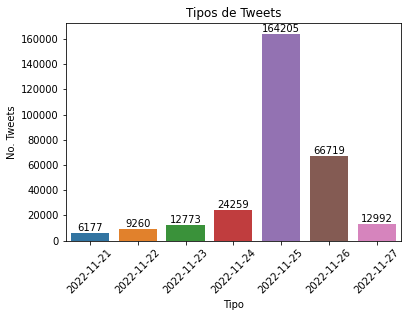

In [35]:
# Gráfico de tweets por fecha
ax = sns.barplot(x='tweet_date', y='id_tweet', data=df_fecha)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
ax.set(xlabel='Tipo', ylabel='No. Tweets',title="Tipos de Tweets")

### 3.3.4.	Términos más utilizados en los tweets

In [36]:
#Analisis de terminos mas utilizados

In [37]:
# Word cloud texto del tweet original

df_tweet_original = df_tweets.loc[df_tweets['type_rt'] == "N/A"]

#Palabras más frecuentes
palabras = " ".join(df_tweet_original['clean_text'])
palabras = str(palabras)

In [38]:
listado = pd.DataFrame(Counter(palabras.split()).most_common())
listado.columns = ['palabra','veces']

In [39]:
listado = listado.iloc[0:20,]

In [40]:
#Términos mas utilizados
listado

,palabra,veces
0,violencia,22877
1,mujeres,14659
2,día,9104
3,internacional,6771
4,mujer,6539
5,eliminación,6295
6,hoy,4964
7,género,4897
8,todas,3606
9,violencias,2613


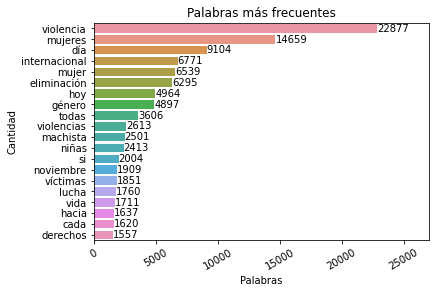

In [41]:
#Gráfico de términos más utilizados
ax = sns.barplot(x='veces', y='palabra', data=listado)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Palabras', ylabel='Cantidad', title="Palabras más frecuentes")
ax.set(xlim=(0, 27000))
ax.tick_params(axis='x', rotation=30)

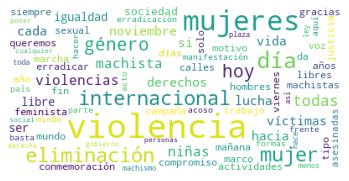

In [42]:
#Word cloud de términos más utilizados
wordcloud = WordCloud(background_color="white",max_words=80,max_font_size=40, relative_scaling=.5, collocations=False, normalize_plurals=False).generate(palabras)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

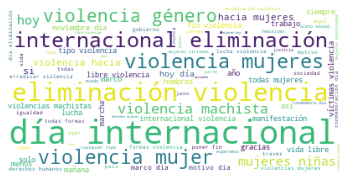

In [43]:
#Word cloud de términos más utilizados (bigramas)
wordcloud = WordCloud(background_color="white",max_words=80,max_font_size=40, relative_scaling=.5, collocations=True, normalize_plurals=False).generate(palabras)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [44]:
# Word cloud texto de los tweets con mayor impacto
#Tweets relevantes
df_tweets_relevantes = df_tweets.groupby(['id_rt_tweet','clean_text'], as_index=False).count()
df_tweets_relevantes = df_tweets_relevantes[df_tweets_relevantes['id_rt_tweet'] != 0]
df_tweets_relevantes = df_tweets_relevantes.iloc[:,0:3]
df_tweets_relevantes = df_tweets_relevantes[df_tweets_relevantes['id_tweet']>=200]

In [45]:
df_tweets_relevantes.head()

,id_rt_tweet,clean_text,id_tweet
34331,1463825457955196929,rt día internacional violencia género,225
35575,1594619123316703236,rt recordamos día diversidad inclusión día tra...,367
36620,1594752510912249877,rt atención mañana carne cruda entrevistamos r...,508
36850,1594782024077873195,rt noviembre día internacional eliminación vio...,211
38233,1595047438628360192,rt mujer violada sitp cuerpo vida niña encontr...,243


In [46]:
tweets_relevantes = df_tweets_relevantes.sort_values(by='id_tweet',ascending=False).head(5)
tweets_relevantes

,id_rt_tweet,clean_text,id_tweet
58268,1596053727521099776,rt violencia física violencia sexual violencia...,7156
94919,1596226621232455680,rt ahora madrid manifestación feminista,2506
108812,1596323972651823104,rt domingo marcha llenará personas colocan hom...,2084
88567,1596197132570173440,rt dejemos recordar siguen matando chica subió...,2009
101564,1596258206690545670,rt viva lucha mujeres,1904


In [47]:
tweets_relevantes_id = list(tweets_relevantes.iloc[:,0])
tweets_relevantes_id

[1596053727521099776,
 1596226621232455680,
 1596323972651823104,
 1596197132570173440,
 1596258206690545670]

In [48]:
#Palabras más frecuentes
palabras = " ".join(df_tweets_relevantes['clean_text'])
palabras = str(palabras)

In [49]:
listado = pd.DataFrame(Counter(palabras.split()).most_common())
listado.columns = ['palabra','veces']

In [50]:
listado = listado.iloc[1:11,]
palabras_new = " ".join(listado['palabra'])
palabras_new = str(palabras_new)

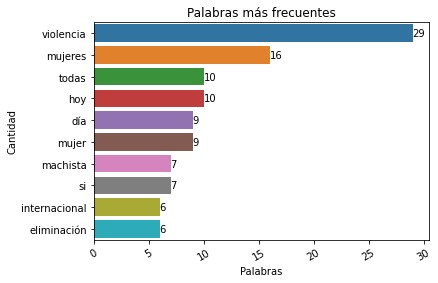

In [51]:
#Palabras más frecuentes tweets relevantes
ax = sns.barplot(x='veces', y='palabra', data=listado)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Palabras', ylabel='Cantidad', title="Palabras más frecuentes")
#ax.set(xlim=(0, 27000))
ax.tick_params(axis='x', rotation=30)

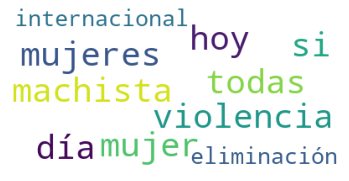

In [52]:
# Word CloudPalabras más frecuentes tweets relevantes
wordcloud = WordCloud(background_color="white",max_words=80,max_font_size=40, relative_scaling=.5, collocations=True, normalize_plurals=False).generate(palabras_new)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 3.3.5.	Perfil de los usuarios

In [53]:
# Cantidad de usuarios únicos
print("Número de usuarios únicos: %d" % df_usuarios.shape[0])

Número de usuarios únicos: 148433


In [54]:
#Valores nulos en usuarios
print(" \nValores nulos en usuarios : \n\n",
      df_usuarios.isnull().sum())

 
Valores nulos en usuarios : 

 username                 0
description          35481
location             80986
clean_descripcion        0
dtype: int64


In [55]:
# Word cloud texto de la descripcion de los usuarios

#Palabras más frecuentes
palabras = " ".join(df_usuarios['clean_descripcion'])
palabras = str(palabras)

In [56]:
listado = pd.DataFrame(Counter(palabras.split()).most_common())
listado.columns = ['palabra','veces']

In [57]:
listado = listado.iloc[1:10,]

In [58]:
# Palabras más frecuentes en la descripcion de los usuarios
listado.head()

,palabra,veces
1,feminista,3916
2,vida,3606
3,social,3518
4,oficial,3439
5,cuenta,2954


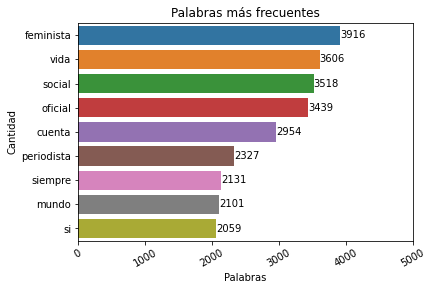

In [59]:
# Palabras más frecuentes en la descripcion de los usuarios
ax = sns.barplot(x='veces', y='palabra', data=listado)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Palabras', ylabel='Cantidad', title="Palabras más frecuentes")
ax.set(xlim=(0, 5000))
ax.tick_params(axis='x', rotation=30)

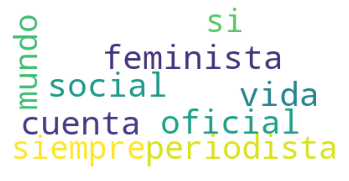

In [60]:
# Wordcloud Palabras más frecuentes en la descripcion de los usuarios
palabras_new = " ".join(listado['palabra'])
palabras_new = str(palabras_new)
wordcloud = WordCloud(background_color="white",max_words=80,max_font_size=40, relative_scaling=.5, collocations=False, normalize_plurals=False).generate(palabras_new)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [61]:
#Usuarios por localización de acuerdo a la descripción
df_lugar = df_usuarios.groupby(['location'])['username'].count().reset_index()
df_lugar['porcentaje'] = df_lugar['username']/df_lugar.shape[0]*100
df_lugar.sort_values(by='username',ascending=False).head(10)

,location,username,porcentaje
13640,México,1467,6.200600
8127,España,1425,6.023078
11923,Madrid,1142,4.826916
3312,"Bogotá, D.C., Colombia",984,4.159094
5685,Colombia,926,3.913944
12073,"Madrid, Comunidad de Madrid",898,3.795596
11388,"Lima, Peru",624,2.637474
1909,Argentina,612,2.586753
5494,Ciudad de México,472,1.995012
3542,"Buenos Aires, Argentina",466,1.969652


### 3.3.6.	Tweets con más retweets

In [62]:
lista_tweets = tweets_relevantes_id
df_tweet_import = df_tweets.loc[df_tweets['id_tweet'].isin(lista_tweets)] 

In [63]:
df_tweet_import

,id_tweet,username,tweet_text,tweet_created_at,tweet_lang,id_rt_tweet,type_rt,description,location,tweet_date,target_username,clean_text
57654,1596053727521099776,IreneMontero,Violencia física\nViolencia sexual\nViolencia ...,2022-11-25 08:10:36,es,0,N/A,Psicóloga. Feminista. Madre de 3. Ministra de ...,Madrid,2022-11-25,NaN,violencia física violencia sexual violencia ps...
159756,1596226621232455680,LaEtxebarria,Ahora en Madrid. manifestación feminista #25N ...,2022-11-25 19:37:37,es,0,N/A,"No milito en ningún partido, asociación, la ag...",Neverland,2022-11-25,NaN,ahora madrid manifestación feminista
179206,1596258206690545670,IreneMontero,Que viva la lucha de las mujeres ✊️💜 #25N http...,2022-11-25 21:43:08,es,0,N/A,Psicóloga. Feminista. Madre de 3. Ministra de ...,Madrid,2022-11-25,NaN,viva lucha mujeres
208566,1596323972651823104,DeniseDresserG,"El domingo, la contra-marcha se llenará de per...",2022-11-26 02:04:28,es,0,N/A,"Politóloga, escritora, activista, mamá de 3 hu...",Ciudad de México,2022-11-26,NaN,domingo marcha llenará personas colocan hombre...
287598,1596197132570173440,CasifuiRaul,No dejemos de recordar que nos siguen matando....,2022-11-25 17:40:26,es,0,N/A,Le digo EL HIJO a mi hijo.,Argentina,2022-11-25,NaN,dejemos recordar siguen matando chica subió re...


## 3.4.	Modelado y evaluación

### 3.4.1.	Construcción del grafo

In [64]:
# Dataframe con la informacion del grafo
df_grafo = df_tweets[['username','target_username','id_tweet']]

In [65]:
df_grafo.shape

(296385, 3)

In [66]:
df_grafo.replace('', np.nan, inplace=True)
df_grafo.head()

C:\Users\aemartinez\Anaconda3\lib\site-packages\pandas\core\frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


,username,target_username,id_tweet
0,RostroColectivo,NaN,1594506213009629187
1,drjasf1,lagunes28,1594507056245096448
2,Allyta13,sybelmartinez,1594507073584234496
3,esloque68112740,Salome181,1594507130748522496
4,mariapprada,UJIuniversitat,1594507202823348229


In [67]:
df_grafo = df_grafo.dropna(how='any',axis=0) 

In [68]:
df_grafo = df_grafo[df_grafo['username'] != df_grafo['target_username']]

In [69]:
df_grafo.shape

(249662, 3)

In [70]:
df_grafo_2 = df_grafo.groupby(['username','target_username'], as_index=False).count()

In [71]:
df_grafo_2.shape

(216225, 3)

In [72]:
df_grafo_2.head()

,username,target_username,id_tweet
0,00001009082AA,LadyExtrema,1
1,00001009082AA,QuoRedFeminismo,1
2,00001009082AA,marialozano777,1
3,0000Jgr,IreneMontero,1
4,0005Dylan,Rita_Maestre,1


In [73]:
df_grafo_2.sort_values(by='id_tweet',ascending=False).head(5)

,username,target_username,id_tweet
176465,magealcamus552,de_observer,95
50334,Igartecia,de_observer,78
20099,CahuanaBeatriz,ManuelaRamos,73
93107,Pato21061966,de_observer,65
106096,Sar98Bierzo,de_observer,57


In [74]:
df_grafo_2.rename(columns = {'id_tweet': 'weight'}, inplace = True)

In [75]:
# Dataframe del Grafo final
df_grafo_2.sort_values(by='weight',ascending=False).head(5)

,username,target_username,weight
176465,magealcamus552,de_observer,95
50334,Igartecia,de_observer,78
20099,CahuanaBeatriz,ManuelaRamos,73
93107,Pato21061966,de_observer,65
106096,Sar98Bierzo,de_observer,57


In [76]:
# Modelamiento del Grafo final
g = nx.from_pandas_edgelist(df_grafo_2 ,'username','target_username',edge_attr= 'weight',create_using=nx.DiGraph())

In [77]:
# Mostramos el número de nodos y aristas del grafo dirigido
print("El grafo dirigido tiene {} nodos y {} aristas. La proporción de aristas y nodos es aproximadamente {} a 1 "
      .format(g.number_of_nodes(), g.number_of_edges(), round(g.number_of_edges()/g.number_of_nodes(),0) ))

El grafo dirigido tiene 138730 nodos y 216225 aristas. La proporción de aristas y nodos es aproximadamente 2.0 a 1 


In [78]:
# Creamos una lista con los grados de todos los nodos del grafo
degrees = [d for _, d in g.degree()] # Grado 
# Mostramos estadísticos sobre los grados
print('El grado máximo del grafo es: {}'.format(max(degrees)))
print('El grado mínimo del grafo es: {}'.format(min(degrees)))
print('La media de los grados del grafo es: {}'.format(np.mean(degrees)))
print('La mediana de los grados del grafo es: {}'.format(np.median(degrees)))

El grado máximo del grafo es: 11623
El grado mínimo del grafo es: 1
La media de los grados del grafo es: 3.1172060837598212
La mediana de los grados del grafo es: 1.0


In [79]:
# Creamos un dataframe con los nodos y sus grados
nodos_degrees = [(x,y) for x, y in g.degree()] # Grado
nodos_degrees = pd.DataFrame(nodos_degrees, columns=['usuario', 'grado'])

In [80]:
#Obtenemos la cantidad de nodos por cada grado y el porcentaje que representan para el total de nodos
n_nodos = nodos_degrees.groupby(['grado']).count()
n_nodos['porcentaje']=n_nodos['usuario']/g.number_of_nodes()*100
n_nodos.head(10)

,usuario,porcentaje
grado,,
1,96554,69.598501
2,19223,13.856412
3,7396,5.331219
4,3700,2.667051
5,2286,1.647805
6,1541,1.110791
7,1086,0.782816
8,887,0.639371
9,679,0.489440


In [81]:
#Obtenemos los 10 nodos más importantes del grafo
nodos_degrees.sort_values(by=['grado'], ascending=False).head()

,usuario,grado
5,IreneMontero,11623
78,LaEtxebarria,3412
36,DeniseDresserG,2810
68,CasifuiRaul,2012
148,PizarroMariaJo,1744


In [82]:
# Creamos una lista con los grados de todos los nodos del grafo
in_degrees = [d for _, d in g.in_degree()] # Grado 
# Mostramos estadísticos sobre los grados
print('El grado máximo de entrada del grafo es: {}'.format(max(in_degrees)))
print('El grado mínimo de entrada del grafo es: {}'.format(min(in_degrees)))
print('La media de entrada de los grados del grafo es: {}'.format(np.mean(in_degrees)))
print('La mediana de entrada de los grados del grafo es: {}'.format(np.median(in_degrees)))

El grado máximo de entrada del grafo es: 11622
El grado mínimo de entrada del grafo es: 0
La media de entrada de los grados del grafo es: 1.5586030418799106
La mediana de entrada de los grados del grafo es: 0.0


In [83]:
# Creamos un dataframe con los nodos y sus grados
nodos_in_degrees = [(x,y) for x, y in g.in_degree()] # Grado
nodos_in_degrees = pd.DataFrame(nodos_in_degrees, columns=['usuario', 'grado_entrada'])

In [84]:
#Obtenemos los 10 nodos más importantes del grafo
nodos_in_degrees.sort_values(by=['grado_entrada'], ascending=False).head()

,usuario,grado_entrada
5,IreneMontero,11622
78,LaEtxebarria,3408
36,DeniseDresserG,2808
68,CasifuiRaul,2012
148,PizarroMariaJo,1744


In [85]:
# Creamos una lista con los grados de todos los nodos del grafo
out_degrees = [d for _, d in g.out_degree()] # Grado 
# Mostramos estadísticos sobre los grados
print('El grado máximo de salida del grafo es: {}'.format(max(out_degrees)))
print('El grado mínimo de salida del grafo es: {}'.format(min(out_degrees)))
print('La media de salida de los grados del grafo es: {}'.format(np.mean(out_degrees)))
print('La mediana de salida de los grados del grafo es: {}'.format(np.median(out_degrees)))

El grado máximo de entrada del grafo es: 638
El grado mínimo de entrada del grafo es: 0
La media de entrada de los grados del grafo es: 1.5586030418799106
La mediana de entrada de los grados del grafo es: 1.0


In [87]:
# Creamos un dataframe con los nodos y sus grados
nodos_out_degrees = [(x,y) for x, y in g.out_degree()] # Grado
nodos_out_degrees = pd.DataFrame(nodos_out_degrees, columns=['usuario', 'grado_salida'])

In [88]:
#Obtenemos los 10 nodos más importantes del grafo
nodos_out_degrees.sort_values(by=['grado_salida'], ascending=False).head()

,usuario,grado_salida
122771,notasausencia,638
4245,BEBES_ROBADOS_,98
97374,elmojama4,91
12495,EllaComica,90
48320,LilianaAmeiro,78


In [89]:
#Densidad del grafo
print("Densidad: %f" % (nx.density(g)*100))

Densidad: 0.001123


### 3.4.2.	Algoritmos de deteccion de comunidades

### 3.4.2.1.	Método Louvain (Gephi)

In [90]:
# Guardamos el grafo en formato graphml
#nx.write_graphml_lxml(g, "grafo_completo_25N.graphml")
#Fuente: https://networkx.org/documentation/stable/reference/readwrite/graphml.html

Cargamos el grafo desde Gephi con la detección de comunidades con Resolución 1

In [91]:
# Grafico con comunidades resolución 1
G_lovain = nx.read_graphml("graph_lovain_completo.graphml")

In [92]:
# Creamos un dataframe con los nodos y sus comunidades
nodos_comunidad = [x for x in G_lovain.nodes(data='Modularity Class')]
nodos_comunidad = pd.DataFrame(nodos_comunidad, columns=['usuario', 'comunidad'])
nodos = nodos_degrees.merge(nodos_comunidad)

In [93]:
#Comunidades con mas usuarios
usuarios_louvain = nodos.groupby(['comunidad'], as_index=False).count().sort_values(by='usuario',ascending=False)
usuarios_louvain = usuarios_louvain.drop(['grado'], axis=1)
usuarios_louvain['porcentaje'] = usuarios_louvain['usuario'] / len(usuarios_louvain)
usuarios_louvain.head(11)

,comunidad,usuario,porcentaje
12,12,17385,8.559823
4,4,9946,4.897095
2,2,7829,3.854751
38,38,7463,3.674545
15,15,7139,3.515017
57,57,6244,3.074348
228,228,5579,2.746923
5,5,4550,2.240276
24,24,4545,2.237814
213,213,3881,1.910881


In [94]:
print("Número de comunidades: %d" % len(usuarios_louvain))

Número de comunidades: 2031


In [95]:
comunidades = list(usuarios_louvain['comunidad'].head(11))
comunidades

[12, 4, 2, 38, 15, 57, 228, 5, 24, 213, 212]

Cargamos el grafo desde Gephi con la detección de comunidades con Resolución 2

In [96]:
# Grafico con comunidades resolución 1
G_lovain_2 = nx.read_graphml("graph_lovain_completo_res2.graphml")

In [97]:
# Creamos un dataframe con los nodos y sus comunidades
nodos_comunidad2 = [x for x in G_lovain_2.nodes(data='Modularity Class')]
nodos_comunidad2 = pd.DataFrame(nodos_comunidad2, columns=['usuario', 'comunidad'])
nodos2 = nodos_degrees.merge(nodos_comunidad2)

In [98]:
# Comunidades con mas usuarios
usuarios_louvain2 = nodos2.groupby(['comunidad'], as_index=False).count().sort_values(by='usuario',ascending=False)
usuarios_louvain2 = usuarios_louvain2.drop(['grado'], axis=1)
usuarios_louvain2['porcentaje'] = usuarios_louvain2['usuario'] / len(usuarios_louvain2)
usuarios_louvain2.head(10)

,comunidad,usuario,porcentaje
594,594,24537,12.311591
42,42,17486,8.773708
586,586,10613,5.325138
340,340,10330,5.183141
325,325,6912,3.468138
561,561,6611,3.317110
958,958,5789,2.904666
43,43,5491,2.755143
9,9,5184,2.601104
381,381,4599,2.307577


In [99]:
print("Número de comunidades: %d" % len(usuarios_louvain2))

Número de comunidades: 1993


### 3.4.2.2.	Clauset-Newman-Moore (greedy modularity)

In [100]:
# Se utiliza el modulo de Networkx
communities_generator = nx_comm.greedy_modularity_communities(g, weight='weight', resolution=2)


In [101]:
print("Número de comunidades: %d" % len(communities_generator))


Número de comunidades: 2266


In [102]:
print("Modularidad: %f" % nx_comm.modularity(g, communities_generator, resolution=2))


Modularidad: 0.784145


In [103]:
i=0
with open('lista_comunities.txt', 'w') as f:
    for line in communities_generator:
        i=i+1
        #f.write("%s\n" % line)
        f.write(str(i) + ':'+str(line)+ '\n')

### 3.4.2.3.	Propagación de etiquetas (asynchronous label propagation)

In [104]:
communities_generator2 = nx_comm.asyn_lpa_communities(g, weight='weight', seed=123)

In [105]:
i=0
with open('output2.txt', 'w') as f:
    for exp in communities_generator2:
        i=i+1
        f.write(str(i) + ':'+str(exp)+ '\n')
        

In [106]:
print("Número de comunidades: %d" % i)

Número de comunidades: 7538


In [107]:
communities_generator2 = nx_comm.asyn_lpa_communities(g, weight='weight', seed=123)

In [108]:
print("Modularidad: %f" % nx_comm.modularity(g, communities_generator2))

Modularidad: 0.680503


### 3.4.4.	Comunidades detectadas

Se realiza el análisis de las comunidades detectadas con el algoritmo Louvain con resolución 1

In [109]:
# Creamos un dataframe con los nodos y su centralidad de grado
centralidad_grado = nx.degree_centrality(g)
#centralidad
d_centralidad_grados = dict(sorted(centralidad_grado.items(), key=lambda item: item[1], reverse = True))
#nodos_degrees = pd.DataFrame(nodos_degrees, columns=['usuario', 'grado'])

df_centralidad_grados = pd.DataFrame(list(d_centralidad_grados.items()), columns=['usuario', 'centralidad_grado'])
df_centralidad_grados.head() 

,usuario,centralidad_grado
0,IreneMontero,0.083782
1,LaEtxebarria,0.024595
2,DeniseDresserG,0.020255
3,CasifuiRaul,0.014503
4,PizarroMariaJo,0.012571


In [110]:
df_nodos = nodos.merge(df_centralidad_grados)

In [111]:
df_nodos.head()

,usuario,grado,comunidad,centralidad_grado
0,00001009082AA,3,13,0.000022
1,LadyExtrema,643,12,0.004635
2,QuoRedFeminismo,138,13,0.000995
3,marialozano777,153,13,0.001103
4,0000Jgr,1,12,0.000007


In [112]:
medidas_nodos= df_nodos.sort_values(['grado', 'comunidad'], ascending=False).head(50)

In [113]:
medidas_nodos

,usuario,grado,comunidad,centralidad_grado
5,IreneMontero,11623,12,0.083782
78,LaEtxebarria,3412,212,0.024595
36,DeniseDresserG,2810,2,0.020255
68,CasifuiRaul,2012,15,0.014503
148,PizarroMariaJo,1744,4,0.012571
29,VickyRosell,1702,12,0.012269
205,FranciaMarquezM,1532,4,0.011043
23,i_alaniis,1513,2,0.010906
152,ceciliaencina,1496,12,0.010784
101,periodistatrans,1477,228,0.010647


In [114]:
# Top usuarios por comunidades mas grandes
# Filtro comunidades

comunidades_top = nodos[nodos['comunidad'].isin(comunidades)]
comunidades_top = comunidades_top.set_index('usuario')


In [115]:
comunidades_top.groupby('comunidad').grado.nlargest(5).reset_index()

,comunidad,usuario,grado
0,2,DeniseDresserG,2810
1,2,i_alaniis,1513
2,2,avieu,857
3,2,XochitlGalvez,686
4,2,CastelloPRD,512
5,4,PizarroMariaJo,1744
6,4,FranciaMarquezM,1532
7,4,VivianaVargasVi,1292
8,4,andreanimalidad,350
9,4,PATATAdibujo,296


In [116]:
usuarios_imp_comunidad = comunidades_top.groupby('comunidad').grado.nlargest(1).reset_index()
lista_usuarios = list(usuarios_imp_comunidad.usuario)
lista_usuarios

['DeniseDresserG',
 'PizarroMariaJo',
 'SaninPazC',
 'IreneMontero',
 'CasifuiRaul',
 'gabrielboric',
 'sanchezcastejon',
 'AnaDeAlejandro',
 'LaEtxebarria',
 'radiolacalle',
 'periodistatrans']

In [117]:
df_tweets_relevantes.rename(columns = {'id_tweet': 'no_rt'}, inplace = True)
df_tweets_relevantes.head()

,id_rt_tweet,clean_text,no_rt
34331,1463825457955196929,rt día internacional violencia género,225
35575,1594619123316703236,rt recordamos día diversidad inclusión día tra...,367
36620,1594752510912249877,rt atención mañana carne cruda entrevistamos r...,508
36850,1594782024077873195,rt noviembre día internacional eliminación vio...,211
38233,1595047438628360192,rt mujer violada sitp cuerpo vida niña encontr...,243


In [118]:
#Tweets relevantes en cada comunidad
df_tweet_comunidad = pd.merge(df_tweets_relevantes, 
                     df_tweets.iloc[:,0:3], 
                     left_on ='id_rt_tweet', 
                     right_on ='id_tweet', 
                     how ='left',
                    suffixes=('', '_y'))

In [119]:
df_tweet_comunidad.head()

,id_rt_tweet,clean_text,no_rt,id_tweet,username,tweet_text
0,1463825457955196929,rt día internacional violencia género,225,NaN,NaN,NaN
1,1594619123316703236,rt recordamos día diversidad inclusión día tra...,367,1.594619e+18,LGB_Madrid,Recordamos que el #25N no es un día de diversi...
2,1594752510912249877,rt atención mañana carne cruda entrevistamos r...,508,1.594753e+18,carnecrudaradio,¡ATENCIÓN!\n\nMAÑANA en Carne Cruda entrevista...
3,1594782024077873195,rt noviembre día internacional eliminación vio...,211,1.594782e+18,ONUMujeresMX,El 25 de noviembre es el Día Internacional de ...
4,1595047438628360192,rt mujer violada sitp cuerpo vida niña encontr...,243,1.595047e+18,VivianaVargasVi,Otra mujer violada en un SITP. Otro cuerpo sin...


In [120]:
df_tweet_comunidad[df_tweet_comunidad['username'].isin(lista_usuarios)]

,id_rt_tweet,clean_text,no_rt,id_tweet,username,tweet_text
18,1596052685328982027,rt aspirar país libre violencia machista oblig...,893,1.596053e+18,sanchezcastejon,Aspirar a un país libre de violencia machista ...
19,1596053727521099776,rt violencia física violencia sexual violencia...,7156,1.596054e+18,IreneMontero,Violencia física\nViolencia sexual\nViolencia ...
47,1596153766973411329,rt denuncia hoy medio audiencia plataforma hac...,958,1.596154e+18,PizarroMariaJo,🔴 Denuncia 🔴 \nHoy en medio de la audiencia de...
51,1596176069597356032,rt decimos volvemos parte solución avanzamos e...,696,1.596176e+18,gabrielboric,"Cuando decimos #SíEsMiProblema, nos volvemos p..."
53,1596184233180921857,rt hackeo plataforma desarrollábamos audiencia...,222,1.596184e+18,PizarroMariaJo,Sobre el hackeo a la plataforma donde desarrol...
56,1596197132570173440,rt dejemos recordar siguen matando chica subió...,2009,1.596197e+18,CasifuiRaul,No dejemos de recordar que nos siguen matando....
59,1596226621232455680,rt ahora madrid manifestación feminista,2506,1.596227e+18,LaEtxebarria,Ahora en Madrid. manifestación feminista #25N ...
61,1596235224509448193,rt dice mujeres personas menstruantes personas...,943,1.596235e+18,SaninPazC,"Se dice ""mujeres"". No ""personas menstruantes"" ..."
65,1596257310556372993,rt atención madre maría belén bernal presente ...,377,1.596257e+18,radiolacalle,"ATENCIÓN | La madre de María Belén Bernal, pre..."
66,1596258206690545670,rt viva lucha mujeres,1904,1.596258e+18,IreneMontero,Que viva la lucha de las mujeres ✊️💜 #25N http...


In [121]:
usuarios_imp_comunidad2 = comunidades_top.groupby('comunidad').grado.nlargest(5).reset_index()
lista_usuarios_completo = list(usuarios_imp_comunidad2.usuario)
usuarios_imp_comunidad2

,comunidad,usuario,grado
0,2,DeniseDresserG,2810
1,2,i_alaniis,1513
2,2,avieu,857
3,2,XochitlGalvez,686
4,2,CastelloPRD,512
5,4,PizarroMariaJo,1744
6,4,FranciaMarquezM,1532
7,4,VivianaVargasVi,1292
8,4,andreanimalidad,350
9,4,PATATAdibujo,296


In [122]:
descripcion_usuarios = df_usuarios[df_usuarios['username'].isin(lista_usuarios_completo)]

In [123]:
descripcion_usuarios

,username,description,location,clean_descripcion
611,LGB_Madrid,"Grupo de lesbianas, gays y bisexuales de la Co...",None,grupo lesbianas gays bisexuales comunidad madr...
1021,tamy_idrobo,Feminista Bisexual Ecuatoriana y Cholandesa Co...,Poray ando,feminista bisexual ecuatoriana cholandesa cons...
2595,ceciliaencina,"De la escuela pública a la que fui, salió un P...",València,escuela pública salió premio nobel paz
3290,amnistiamexico,🕯️ Somos la organización defensora de derechos...,México,organización defensora derechos humanos grande...
3365,FamiliasNi,Colectivo de Familiares de Víctimas de Feminic...,None,colectivo familiares víctimas feminicidio busc...
5543,WaykaPeru,Más que periodismo.,"Lima, Peru",periodismo
5922,sybelmartinez,,None,
8735,ContraBorrado,Sexo es la categoría biológica sobre la que se...,None,sexo categoría biológica construye sexismo gén...
9012,VivianaVargasVi,Excandidata al senado. Abogada defensora de DD...,None,excandidata senado abogada defensora ddhh sobr...
10455,totiorellanag,"Ministra de @minmujeryEG. Feminista, madre por...",Chile,ministra feminista madre periodista trabajando...


In [277]:
# definimos una funcion para obtener los hashtags mas importantes de la comunidad
def hash_comunidad(no_comunidad):
    usuarios = nodos[nodos['comunidad']==no_comunidad]
    usuarios_lista = list(usuarios['usuario'])
    # Filtro Tweets originales
    df_tweets_213 = df_tweet_original[df_tweet_original['username'].isin(usuarios_lista)]
    # Se generan los hashtags de la comunidad
    df2_213 = df2[df2['username'].isin(usuarios_lista)]
    df3 = df2_213.iloc[:,11:-1]
    df4 = df3.values.tolist()
    flat_list = [item for sublist in df4 for item in sublist]
    df_hashtags_213 = pd.DataFrame(flat_list)
    df_hashtags_213.replace('', np.nan, inplace=True)
    df_hashtags_213= df_hashtags_213.dropna().reset_index(drop=True)
    df_hashtags_213.columns = ['hashtags']
    df_hashtags_213.loc[:,'hashtags'] = df_hashtags_213.loc[:,'hashtags'].str.lower()
    aux2 = df_hashtags_213.hashtags.value_counts()
    h_groups = pd.DataFrame(aux2).reset_index().head(10)
    ax = sns.barplot(x='hashtags', y='index', data=h_groups)
    ax.bar_label(ax.containers[0])
    ax.set(xlabel='Hashtags', ylabel='No.', title="Frecuencia de Hashtags")
    #ax.set(xlim=(0, 4500))
    
# definimos una funcion para obtener los terminos mas utilizados en la descripcion de usuarios de la comunidad
def usuarios_comunidad(no_comunidad):
    usuarios = nodos[nodos['comunidad']==no_comunidad]
    usuarios_lista = list(usuarios['usuario'])
    # Filtro Usuarios
    df_usuarios_213 = df_usuarios[df_usuarios['username'].isin(usuarios_lista)]
    #Palabras más frecuentes
    palabras = " ".join(df_usuarios_213['clean_descripcion'])
    palabras = str(palabras)
    listado = pd.DataFrame(Counter(palabras.split()).most_common())
    listado.columns = ['palabra','veces']
    listado = listado.iloc[1:10,]
    # Palabras más frecuentes en la descripcion de los usuarios
    ax = sns.barplot(x='veces', y='palabra', data=listado)
    ax.bar_label(ax.containers[0])
    ax.set(xlabel='Palabras', ylabel='Cantidad', title="Palabras más frecuentes")
    #ax.set(xlim=(0, 200))
    ax.tick_params(axis='x', rotation=30)


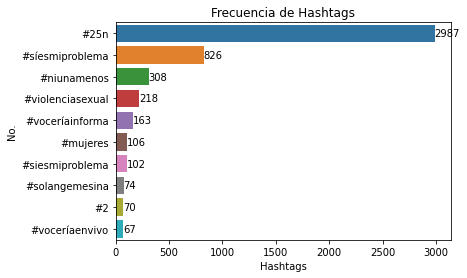

In [292]:
#Hashtags importantes en cada comunidad
hash_comunidad(24)

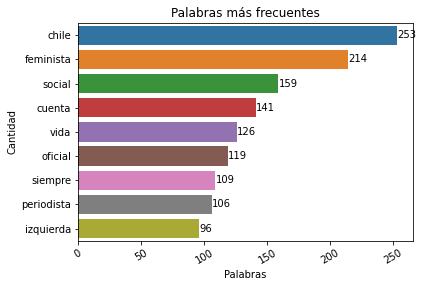

In [293]:
#Descripcion de usuarios en cada comunidad
usuarios_comunidad(24)

### 3.4.5.	Analisis de la comunidad 213 (Ecuador)

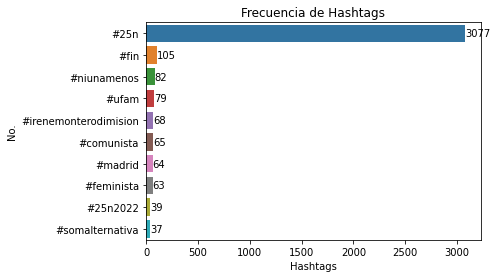

In [297]:
#Hashtags para la comunidad 213
hash_comunidad(212)

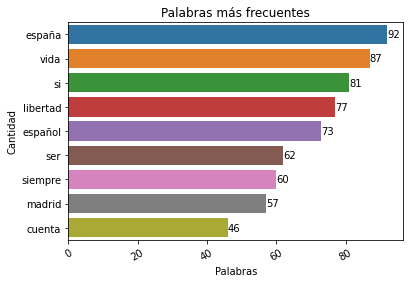

In [295]:
# Usuarios por comunidad
usuarios_comunidad(212)

In [259]:
#Palabras más frecuentes
palabras = " ".join(df_tweets_213['clean_text'])
palabras = str(palabras)
listado = pd.DataFrame(Counter(palabras.split()).most_common())
listado.columns = ['palabra','veces']
listado = listado.iloc[0:20,]
listado

,palabra,veces
0,violencia,497
1,mujeres,338
2,día,231
3,internacional,198
4,eliminación,181
5,mujer,110
6,género,96
7,hoy,85
8,todas,71
9,hacia,62


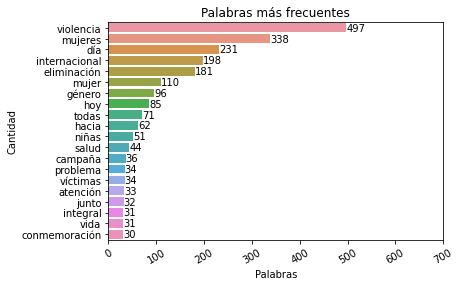

In [260]:
#Gráfico de términos más utilizados
ax = sns.barplot(x='veces', y='palabra', data=listado)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Palabras', ylabel='Cantidad', title="Palabras más frecuentes")
ax.set(xlim=(0, 700))
ax.tick_params(axis='x', rotation=30)

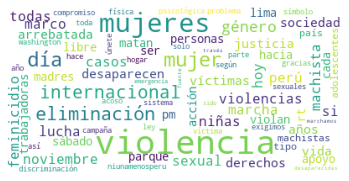

In [225]:
#Word cloud de términos más utilizados
wordcloud = WordCloud(background_color="white",max_words=80,max_font_size=40, relative_scaling=.5, collocations=False, normalize_plurals=False).generate(palabras)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [261]:
# Word cloud texto de la descripcion de los usuarios

#Palabras más frecuentes
palabras = " ".join(df_usuarios_213['clean_descripcion'])
palabras = str(palabras)
listado = pd.DataFrame(Counter(palabras.split()).most_common())
listado.columns = ['palabra','veces']
listado = listado.iloc[1:10,]
listado.head()

,palabra,veces
1,chile,253
2,feminista,214
3,social,159
4,cuenta,141
5,vida,126


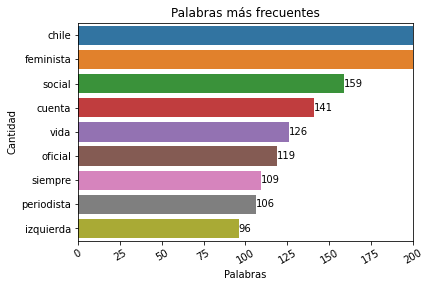

In [262]:
# Palabras más frecuentes en la descripcion de los usuarios
ax = sns.barplot(x='veces', y='palabra', data=listado)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Palabras', ylabel='Cantidad', title="Palabras más frecuentes")
ax.set(xlim=(0, 200))
ax.tick_params(axis='x', rotation=30)

### 3.4.5.1 Subcomunidades en Ecuador

In [145]:
# Filtro Tweets originales
df2_tweet_213 = df_tweets[df_tweets['username'].isin(usuarios_213_ec)]

In [147]:
#Se genera el grafo con la comunidad de Ecuador
df_grafo_213 = df2_tweet_213[['username','target_username','id_tweet']]

In [148]:
df_grafo_213.replace('', np.nan, inplace=True)
df_grafo_213.head()

,username,target_username,id_tweet
2,Allyta13,sybelmartinez,1594507073584234496
3,esloque68112740,Salome181,1594507130748522496
8,capuliazul36,RedFeEc,1594507818178170880
12,RuizCalixto,sybelmartinez,1594508544795099139
14,Naya_AJ,Paovercoutere,1594509301678317568


In [149]:
df_grafo_213 = df_grafo_213.dropna(how='any',axis=0) 
df_grafo_213 = df_grafo_213[df_grafo_213['username'] != df_grafo_213['target_username']]

In [150]:
df_grafo_ec = df_grafo_213.groupby(['username','target_username'], as_index=False).count()

In [151]:
df_grafo_ec.rename(columns = {'id_tweet': 'weight'}, inplace = True)

In [153]:
# Dataframe del Grafo final
df_grafo_ec.sort_values(by='weight',ascending=False).head()

,username,target_username,weight
5783,radiolimontv,FiscaliaEcuador,22
4189,cmmujeres,GuerrayPoder,20
5308,maratonicomujer,GuerrayPoder,12
5871,rikysalsa7,tamy_idrobo,11
6023,sofiacando1980,inredh1,10


In [154]:
# Modelamiento del Grafo 
g_ec = nx.from_pandas_edgelist(df_grafo_ec ,'username','target_username',edge_attr= 'weight',create_using=nx.DiGraph())

In [155]:
# Mostramos el número de nodos y aristas del grafo dirigido
print("El grafo dirigido tiene {} nodos y {} aristas. La proporción de aristas y nodos es aproximadamente {} a 1 "
      .format(g_ec.number_of_nodes(), g_ec.number_of_edges(), round(g_ec.number_of_edges()/g_ec.number_of_nodes(),0) ))

El grafo dirigido tiene 4298 nodos y 6336 aristas. La proporción de aristas y nodos es aproximadamente 1.0 a 1 


In [156]:
#Densidad del grafo
print("Densidad: %f" % (nx.density(g_ec)*100))

Densidad: 0.034307


In [157]:
# Creamos una lista con los grados de todos los nodos del grafo
degrees = [d for _, d in g_ec.degree()] # Grado 
# Mostramos estadísticos sobre los grados
print('El grado máximo del grafo es: {}'.format(max(degrees)))
print('El grado mínimo del grafo es: {}'.format(min(degrees)))
print('La media de los grados del grafo es: {}'.format(np.mean(degrees)))
print('La mediana de los grados del grafo es: {}'.format(np.median(degrees)))

El grado máximo del grafo es: 456
El grado mínimo del grafo es: 1
La media de los grados del grafo es: 2.9483480688692416
La mediana de los grados del grafo es: 1.0


In [158]:
# Creamos una lista con los grados de todos los nodos del grafo
in_degrees = [d for _, d in g_ec.in_degree()] # Grado 
# Mostramos estadísticos sobre los grados
print('El grado máximo de entrada del grafo es: {}'.format(max(in_degrees)))
print('El grado mínimo de entrada del grafo es: {}'.format(min(in_degrees)))
print('La media de entrada de los grados del grafo es: {}'.format(np.mean(in_degrees)))
print('La mediana de entrada de los grados del grafo es: {}'.format(np.median(in_degrees)))

El grado máximo de entrada del grafo es: 456
El grado mínimo de entrada del grafo es: 0
La media de entrada de los grados del grafo es: 1.4741740344346208
La mediana de entrada de los grados del grafo es: 0.0


In [160]:
# Creamos una lista con los grados de todos los nodos del grafo
out_degrees = [d for _, d in g_ec.out_degree()] # Grado 
# Mostramos estadísticos sobre los grados
print('El grado máximo de salida del grafo es: {}'.format(max(out_degrees)))
print('El grado mínimo de salida del grafo es: {}'.format(min(out_degrees)))
print('La media de salida de los grados del grafo es: {}'.format(np.mean(out_degrees)))
print('La mediana de salida de los grados del grafo es: {}'.format(np.median(out_degrees)))

El grado máximo de salida del grafo es: 25
El grado mínimo de salida del grafo es: 0
La media de salida de los grados del grafo es: 1.4741740344346208
La mediana de salida de los grados del grafo es: 1.0


In [161]:
# Creamos un dataframe con los nodos y sus grados
nodos_degrees = [(x,y) for x, y in g_ec.degree()] # Grado
nodos_degrees = pd.DataFrame(nodos_degrees, columns=['usuario', 'grado'])

In [163]:
#Obtenemos la cantidad de nodos por cada grado y el porcentaje que representan para el total de nodos
n_nodos = nodos_degrees.groupby(['grado']).count()
n_nodos['porcentaje']=n_nodos['usuario']/g_ec.number_of_nodes()*100
n_nodos.head(10)

,usuario,porcentaje
grado,,
1,2829,65.821312
2,652,15.169846
3,261,6.072592
4,132,3.071196
5,86,2.000931
6,57,1.326198
7,47,1.093532
8,39,0.907399
9,22,0.511866


In [164]:
#Obtenemos los 10 nodos más importantes del grafo
nodos_degrees.sort_values(by=['grado'], ascending=False).head()

,usuario,grado
5,radiolacalle,456
26,marcelaholguin,278
30,sybelmartinez,191
148,cubalondra,164
50,tamy_idrobo,163


In [165]:
# Creamos un dataframe con los nodos y sus grados
nodos_in_degrees = [(x,y) for x, y in g_ec.in_degree()] # Grado
nodos_in_degrees = pd.DataFrame(nodos_in_degrees, columns=['usuario', 'grado_entrada'])

In [166]:
#Obtenemos los 10 nodos más importantes del grafo
nodos_in_degrees.sort_values(by=['grado_entrada'], ascending=False).head()

,usuario,grado_entrada
5,radiolacalle,456
26,marcelaholguin,278
30,sybelmartinez,183
148,cubalondra,163
50,tamy_idrobo,150


In [168]:
# Creamos un dataframe con los nodos y sus grados
nodos_out_degrees = [(x,y) for x, y in g_ec.out_degree()] # Grado
nodos_out_degrees = pd.DataFrame(nodos_out_degrees, columns=['usuario', 'grado_salida'])

In [169]:
#Obtenemos los 10 nodos más importantes del grafo
nodos_out_degrees.sort_values(by=['grado_salida'], ascending=False).head()

,usuario,grado_salida
754,JorgeLeonLeon,25
2268,Richard99998224,22
313,LaPeriodicanet,20
3973,rebeldedigital1,19
1293,JJCM505,18


In [170]:
# Guardamos el grafo en formato graphml
nx.write_graphml_lxml(g_ec, "grafo_ecuador_25N.graphml")
#Fuente: https://networkx.org/documentation/stable/reference/readwrite/graphml.html